In [1]:
import unicodedata as ud
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
from scipy.optimize import fmin_l_bfgs_b
from tabulate import tabulate
from time import time
from math import ceil, floor
from itertools import product
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import re
import pickle

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

# Data

In [6]:
train = open('/kaggle/input/vn-data-pos/train.txt', encoding='utf-8').readlines()
print('Số lượng từ trong tập train_gold:', len(train))
train[0:5]

Số lượng từ trong tập train_gold: 1225


['Vợ\tN\n', 'anh\tN\n', 'cũng\tR\n', 'thế\tP\n', 'nên\tC\n']

In [7]:
test = open('/kaggle/input/vn-data-pos/test.txt', encoding='utf-8').readlines()
print('Số lượng từ trong tập test_gold:', len(test))
test[0:5]

Số lượng từ trong tập test_gold: 162


['Sau\tE\n', 'nhiều\tA\n', 'đêm\tN\n', 'suy_nghĩ\tV\n', ',\tCH\n']

## Prepare_Data

In [8]:
def build_vocab(gold_data, min_freq=2):
    word_counts = defaultdict(int)
    for line in gold_data:
        line = line.strip()
        if not line:
            continue
        if '\t' in line:
            word = line.split('\t', 1)[0]
        else:
            parts = line.split()
            if len(parts) >= 2:
                word = parts[0]
            else:
                continue
        word_counts[word] += 1

    vocab = {word for word, count in word_counts.items() if count >= min_freq}
    return vocab
    
def prepare_data(gold_data, vocabs_dict=None, add_eos=False):
    sentences = []
    current_sentence = []
    
    sentence_endings = {'.', '!', '?', '...'}
    
    for line in gold_data:
        line = line.strip()
        if not line:  
            if current_sentence:
                if add_eos:
                    current_sentence.append(('</s>', 'EOS'))
                sentences.append(current_sentence)
                current_sentence = []
        else:
            if '\t' in line:
                word, tag = line.split('\t', 1)
            else:
                parts = line.split()
                if len(parts) >= 2:
                    word, tag = parts[0], parts[1]
                else:
                    continue
                    
            if vocabs_dict is not None and word not in vocabs_dict:
                word = '--unk--'
            
            current_sentence.append((word, tag))
            
            if word in sentence_endings:
                if current_sentence:
                    if add_eos:
                        current_sentence.append(('</s>', 'EOS'))
                    sentences.append(current_sentence)
                    current_sentence = []
    
    if current_sentence:
        if add_eos:
            current_sentence.append(('</s>', 'EOS'))
        sentences.append(current_sentence)
    
    return sentences

In [9]:
vocab = build_vocab(train, min_freq=1)
train_sentences = prepare_data(train, vocab, add_eos=False)
test_sentences = prepare_data(test, vocab, add_eos=False)

# MEMM

In [11]:
BEGIN = '*'
DEFAULT_CUTOFF_FRACT = 0.3333333

def vn_metaphone(word):
    import unicodedata
    return ''.join(
        c for c in unicodedata.normalize('NFD', word.lower())
        if unicodedata.category(c) != 'Mn'
    )

class Timer:
    def __init__(self, name):
        self.name = name
        self.__start_time = None
        self.__end_time = None
        self.start()

    def start(self):
        self.__start_time = time()

    def stop(self):
        self.__end_time = time()
        self.__get_elapsed__()

    def __get_elapsed__(self):
        elapsed = (self.__end_time - self.__start_time)
        unit = "seconds"
        if elapsed >= 3600:
            unit = "minutes"
            hours = elapsed / 3600
            minutes = hours % 60
            hours = floor(hours)
            print(self.name, "took", str(hours), "hours and", "{0:.2f}".format(minutes), unit, "to complete")
        elif elapsed >= 60:
            minutes = floor(elapsed / 60)
            seconds = elapsed % 60
            print(self.name, "took", str(minutes), "minutes and", "{0:.2f}".format(seconds), unit, "to complete")
        else:
            print(self.name, "took", "{0:.2f}".format(elapsed), unit, "to complete")

class HistoryTuple:
    def __init__(self, sequence_id, sentence, tags, index):
        if index < 0 or index >= len(sentence):
            raise IndexError
        self.index = index
        self.sequence_id = sequence_id
        self.sentence = sentence
        self.tags = tags
        self.t2, self.t1 = self.__get_previous_tags__(tags)

    def __get_previous_tags__(self, tags):
        """function to retrieve 2 previous tags for word in sentence"""
        if len(self.tags) == 0:
            return None, None
        if self.index == 1:
            return BEGIN, tags[self.index-1]
        elif self.index == 0:
            return BEGIN, BEGIN
        else:
            return tags[self.index-2], tags[self.index-1]

    def getWord(self):
        return self.sentence[self.index]

    def getWordTag(self):
        return self.tags[self.index]

    def getT_2(self):
        return self.t2

    def getT_1(self):
        return self.t1

    def getIndex(self):
        return self.index

    def getTupleKey(self):
        return self.t2, self.t1, self.sequence_id, self.index

    def getPossibleTagSet(self, data, cutoff=None, add_common=False):
        """Return tag set which are possible for a given word"""
        full_tag_set_size = data.getTagSetSize()
        if cutoff is None:
            cutoff = ceil(full_tag_set_size * DEFAULT_CUTOFF_FRACT)
        elif cutoff >= full_tag_set_size:
            return data.getTagSet()
        
        word = self.getWord()
        tags_dict = data.getWordDict().get(word, False)
        if tags_dict is False:
            sorted_tags_list = data.getSortedTagsList()
        else:
            sorted_tags_list = sorted(tags_dict, key=tags_dict.get, reverse=True)
        
        if data.isNumberWord(word) and "M" not in sorted_tags_list[:cutoff]:
            sorted_tags_list.insert(0, "M")
        
        remainder = cutoff - len(sorted_tags_list)
        if remainder < 0:
            return tuple(sorted_tags_list[:cutoff])
        elif add_common is True and remainder > 0:
            top_candidate_tags = data.getSortedTagsList()
            sorted_tags_set = set(sorted_tags_list)
            candidate_set = set(top_candidate_tags) - sorted_tags_set
            while remainder > 0 and top_candidate_tags:
                tag_candidate = top_candidate_tags.pop(0)
                if tag_candidate in candidate_set:
                    sorted_tags_list.append(tag_candidate)
                    remainder -= 1
        return tuple(sorted_tags_list)

class VietnameseDataReader:
    def __init__(self, sentences, file_name="data"):
        self.file = file_name
        self.sentences = []
        self.tags = []
        self.tag_dict = defaultdict(int)
        self.word_dict = defaultdict(dict)
        self.word_tag_dict = defaultdict(int)
        self.numbers = 0
        self.cap_no_start = 0
        self.word_suffixes = {}
        self.word_prefixes = {}
        self.__process_sentences__(sentences)
        self.__make_tuples__()
        self.tags_bigrams, self.tags_trigrams = self.__tagsToNgrams__()
        self.sorted_tags_list = sorted(self.tag_dict, key=self.tag_dict.get, reverse=True)

    def __process_sentences__(self, sentences):
        """Process sentences in [(word, tag), ...] format"""
        for sentence in sentences:
            words = []
            tags = []
            for word, tag in sentence:
                words.append(word)
                tags.append(tag)
                
                # Update dictionaries
                self.word_tag_dict[(word, tag)] += 1
                self.tag_dict[tag] += 1
                
                if word not in self.word_dict:
                    self.word_dict[word] = defaultdict(int)
                self.word_dict[word][tag] += 1
                
                # Count numbers and capitals
                if self.isNumberWord(word):
                    self.numbers += 1
                if word and word[0].isupper() and len(words) > 1:
                    self.cap_no_start += 1
            
            self.sentences.append(tuple(words))
            self.tags.append(tuple(tags))

    def __make_tuples__(self):
        self.sentences = tuple(self.sentences)
        self.tags = tuple(self.tags)

    def __tagsToNgrams__(self):
        """Create trigrams and bigrams from data"""
        bigrams = defaultdict(int)
        trigrams = defaultdict(int)
        for tags in self.getTags():
            tags = list(tags)
            for i in range(2):
                tags.insert(0, BEGIN)
            for k in range(2, len(tags)):
                trigrams[tuple(tags[k-2:k+1])] += 1
                bigrams[tuple(tags[k-1:k+1])] += 1
        return bigrams, trigrams

    def __wordsToSuffixes__(self):
        """Create suffixes for all word,tag pairs"""
        suffixes = defaultdict(int)
        for word, tag in self.getWordTagDict():
            for suffix in self.getSuffixesForWord(word):
                suffixes[(suffix, tag)] += 1
        return suffixes

    def __wordsToPrefixes__(self):
        """Create prefixes for all word,tag pairs"""
        prefixes = defaultdict(int)
        for word, tag in self.getWordTagDict():
            for prefix in self.getPrefixesForWord(word):
                prefixes[(prefix, tag)] += 1
        return prefixes

    def getSuffixesForWord(self, word):
        """Generate suffixes for a given word"""
        suffixes = self.word_suffixes.get(word, False)
        if suffixes is not False:
            return suffixes
        suffixes = []
        if word.isalpha():
            boundary = min(5, len(word))
            for i in range(1, boundary):
                suffixes.append(word[-i:])
        suffixes = tuple(suffixes)
        self.word_suffixes[word] = suffixes
        return suffixes

    def getPrefixesForWord(self, word):
        """Generate prefixes for a given word"""
        prefixes = self.word_prefixes.get(word, False)
        if prefixes is not False:
            return prefixes
        prefixes = []
        if word.isalpha():
            boundary = min(5, len(word))
            for i in range(2, boundary):
                prefixes.append(word[:i])
        prefixes = tuple(prefixes)
        self.word_prefixes[word] = prefixes
        return prefixes

    @staticmethod
    def isNumberWord(word):
        if word.isdigit():
            return True
        elif word.isnumeric():
            return True
        elif word.isdecimal():
            return True
        else:
            for char in ('-', ',', '.', '\/'):
                word = word.replace(char, '')
                if word.isdigit():
                    return True
            return False

    def getTagSet(self):
        return tuple(self.tag_dict.keys())

    def getTagSetSize(self):
        return len(self.tag_dict)

    def getWordDict(self):
        return self.word_dict

    def getTagDict(self):
        return self.tag_dict

    def getTagDictSize(self):
        return len(self.tag_dict)

    def getWordDictSize(self):
        return len(self.word_dict)

    def getSentences(self):
        return self.sentences

    def getTags(self):
        return self.tags

    def getSentencesSize(self):
        return len(self.sentences)

    def getTagsSize(self):
        return len(self.tags)

    def getSentenceByIndex(self, index):
        return self.sentences[index]

    def getTagsByIndex(self, index):
        return self.tags[index]

    def getWordTagDict(self):
        return self.word_tag_dict

    def getSortedTagsList(self):
        return self.sorted_tags_list.copy()

    def getTopNTagsForWord(self, word, n):
        tags_dict = self.getWordDict().get(word, False)
        if tags_dict is False:
            return self.getTopNTags(n)
        sorted_tags = sorted(tags_dict, key=tags_dict.get, reverse=True)
        if n == 1:
            return sorted_tags[0] if sorted_tags else self.sorted_tags_list[0]
        elif n >= len(sorted_tags):
            return sorted_tags
        else:
            return sorted_tags[:n]

    def getTopNTags(self, n):
        if n == 1:
            return self.sorted_tags_list[0]
        elif n >= len(self.sorted_tags_list):
            return self.sorted_tags_list
        else:
            return self.sorted_tags_list[:n]

    def getNumbers(self):
        return self.numbers

    def getCapNoStart(self):
        return self.cap_no_start

    def getCapStart(self):
        return self.getSentencesSize()

class VietnameseFeaturesFactory:
    def __init__(self, data, cutoff=0):
        self.data = data
        self.type = "vietnamese_optimized"
        self._cutoff = cutoff
        self._features_index = {}
        self.histories_dict = {}
        self.null_histories_set = set()
        
        # Từ đơn âm tiết hay đa âm tiết
        self.syllable_info = self.__analyze_syllables__()
        
        self.__generateFeaturesIndex__()

    def __analyze_syllables__(self):
        syllable_info = {}
        for sentence in self.data.getSentences():
            for word in sentence:
                # Đếm số âm tiết bằng cách đếm số dấu gạch dưới + 1
                if '_' in word:
                    # Từ có dấu gạch dưới: "bóng_đá" = 2 âm tiết, "học_sinh_viên" = 3 âm tiết
                    syllable_count = word.count('_') + 1
                else:
                    # Từ đơn âm tiết: "tôi", "đẹp", "nhà" = 1 âm tiết
                    syllable_count = 1
                syllable_info[word] = syllable_count
        return syllable_info

    def getSyllablePrefixes(self, word):
        """Return all syllable-level prefixes for a word (joined by '_'). E.g. 'học_sinh_viên' -> ['học', 'học_sinh']"""
        if '_' not in word:
            return []
        sylls = word.split('_')
        return ['_'.join(sylls[:i]) for i in range(1, len(sylls))]
    
    def getSyllableSuffixes(self, word):
        """Return all syllable-level suffixes for a word (joined by '_'). E.g. 'học_sinh_viên' -> ['viên', 'sinh_viên']"""
        if '_' not in word:
            return []
        sylls = word.split('_')
        return ['_'.join(sylls[i:]) for i in range(1, len(sylls))]

    def getFeaturesIndices(self, tag, history, in_data=True):
        """Lấy feature indices tối ưu cho tiếng Việt"""
        indices = []
        word = history.getWord()
        position = history.getIndex()
        sentence = history.sentence
        
        # 1. f100: (Word,Tag) pair
        if in_data:
            feature_idx = self._features_index.get(("f100", (word, tag)), False)
            if feature_idx is not False:
                indices.append(feature_idx)

        2 # Phonetic (Metaphone) feature
        metaphone = vn_metaphone(word)
        feature_idx = self._features_index.get(("fMetaphone", (metaphone, tag)), False)
        if feature_idx is not False:
            indices.append(feature_idx)
        
        # 3. f103: Trigram Tags
        feature_idx = self._features_index.get(("f103", (history.getT_2(), history.getT_1(), tag)), False)
        if feature_idx is not False:
            indices.append(feature_idx)
        
        # 4. Bigram Tags
        feature_idx = self._features_index.get(("f104", (history.getT_1(), tag)), False)
        if feature_idx is not False:
            indices.append(feature_idx)
        
        # 5. Window features: W_{i-2}, W_{i-1}, W_{i+1}, W_{i+2}
        for offset in [-2, -1, 1, 2]:
            idx = position + offset
            if 0 <= idx < len(sentence):
                context_word = sentence[idx]
                feature_idx = self._features_index.get(("fWindow", (offset, context_word, tag)), False)
                if feature_idx is not False:
                    indices.append(feature_idx)
        
        # 6. Word pair features: (W_{i-1}, W_i), (W_i, W_{i+1})
        if position > 0:
            prev_word = sentence[position - 1]
            feature_idx = self._features_index.get(("fWordPair", (prev_word, word, tag)), False)
            if feature_idx is not False:
                indices.append(feature_idx)
        
        if position < len(sentence) - 1:
            next_word = sentence[position + 1]
            feature_idx = self._features_index.get(("fWordPair", (word, next_word, tag)), False)
            if feature_idx is not False:
                indices.append(feature_idx)
        
        # 7. Punctuation feature
        if tag == 'CH':
            feature_idx = self._features_index.get(("fPunct", tag), False)
            if feature_idx is not False:
                indices.append(feature_idx)
        
        # 8. Number feature
        if tag == 'M':
            feature_idx = self._features_index.get(("fNum", tag), False)
            if feature_idx is not False:
                indices.append(feature_idx)
        
        # 9. Quantifier feature
        if tag == 'L':
            feature_idx = self._features_index.get(("fQuantifier", tag), False)
            if feature_idx is not False:
                indices.append(feature_idx)
        
        # 10. Capitalization features
        if word and word[0].isupper():
            if position == 0:
                feature_idx = self._features_index.get(("fCapStart", tag), False)
                if feature_idx is not False:
                    indices.append(feature_idx)
            else:
                feature_idx = self._features_index.get(("fCapNoStart", tag), False)
                if feature_idx is not False:
                    indices.append(feature_idx)
        
        # 11. Syllable count feature
        syllable_count = self.syllable_info.get(word, 1)
        feature_idx = self._features_index.get(("fSyllable", (syllable_count, tag)), False)
        if feature_idx is not False:
            indices.append(feature_idx)
        
        # 12. Word length feature
        length_category = "short" if len(word) <= 3 else "medium" if len(word) <= 5 else "long"
        feature_idx = self._features_index.get(("fLength", (length_category, tag)), False)
        if feature_idx is not False:
            indices.append(feature_idx)

        # 13. SyllablePrefix
        for prefix in self.getSyllablePrefixes(word):
            feature_idx = self._features_index.get(("fSyllablePrefix", (prefix, tag)), False)
            if feature_idx is not False:
                indices.append(feature_idx)
        
        # 14. SyllableSuffix
        for suffix in self.getSyllableSuffixes(word):
            feature_idx = self._features_index.get(("fSyllableSuffix", (suffix, tag)), False)
            if feature_idx is not False:
                indices.append(feature_idx)
        
        # 15. Position in sentence features
        sent_len = len(sentence)
        if position == 0:
            pos_feature = "first"
        elif position == sent_len - 1:
            pos_feature = "last"
        elif position / sent_len < 0.3:
            pos_feature = "early"
        elif position / sent_len > 0.7:
            pos_feature = "late"
        else:
            pos_feature = "middle"
        
        feature_idx = self._features_index.get(("fPosition", (pos_feature, tag)), False)
        if feature_idx is not False:
            indices.append(feature_idx)
        
        return indices

    def __generateFeaturesIndex__(self):
        """Generate features index cho tất cả features"""
        feature_names = [
            "f100", "f103", "f104", "fWindow", "fWordPair", "fPunct", 
            "fNum", "fQuantifier", "fCapStart", "fCapNoStart", 
            "fSyllable", "fLength", "fPosition",
            "fSyllablePrefix", "fSyllableSuffix", "fMetaphone"
        ]
        
        # Build feature dictionaries
        feature_dicts = {}
        
        # Existing features
        feature_dicts["f100"] = self.data.getWordTagDict()
        feature_dicts["f103"] = self.data.tags_trigrams
        feature_dicts["f104"] = self.data.tags_bigrams
        
        # New features
        feature_dicts.update(self.__build_new_feature_dicts__())
        
        # Generate indices
        keys = []
        for name in feature_names:
            if name in feature_dicts:
                features = []
                for feature in feature_dicts[name].keys():
                    if feature_dicts[name].get(feature) > self._cutoff:
                        features.append((name, feature))
                keys.extend(features)
        
        for i, key in enumerate(keys):
            self._features_index[key] = i
        
        self.features_list = tuple(keys)
        self._features_vector_length = len(keys)

    def __build_new_feature_dicts__(self):
        new_dicts = defaultdict(lambda: defaultdict(int))
        
        for k in range(self.data.getSentencesSize()):
            sentence = self.data.getSentenceByIndex(k)
            tags = self.data.getTagsByIndex(k)
            
            for i, (word, tag) in enumerate(zip(sentence, tags)):
                # Window features
                for offset in [-2, -1, 1, 2]:
                    idx = i + offset
                    if 0 <= idx < len(sentence):
                        context_word = sentence[idx]
                        new_dicts["fWindow"][(offset, context_word, tag)] += 1

                metaphone = vn_metaphone(word)
                new_dicts["fMetaphone"][(metaphone, tag)] += 1
                
                # Word pair features
                if i > 0:
                    prev_word = sentence[i - 1]
                    new_dicts["fWordPair"][(prev_word, word, tag)] += 1
                
                if i < len(sentence) - 1:
                    next_word = sentence[i + 1]
                    new_dicts["fWordPair"][(word, next_word, tag)] += 1
                
                # Punctuation feature
                if tag == 'CH':
                    new_dicts["fPunct"][tag] += 1
                
                # Number feature
                if tag == 'M':
                    new_dicts["fNum"][tag] += 1
                
                # Quantifier feature
                if tag == 'L':
                    new_dicts["fQuantifier"][tag] += 1
                    
                # fSyllablePrefix
                for prefix in self.getSyllablePrefixes(word):
                    new_dicts["fSyllablePrefix"][(prefix, tag)] += 1
                
                # fSyllableSuffix
                for suffix in self.getSyllableSuffixes(word):
                    new_dicts["fSyllableSuffix"][(suffix, tag)] += 1
                
                # Syllable count
                syllable_count = self.syllable_info.get(word, 1)
                new_dicts["fSyllable"][(syllable_count, tag)] += 1
                
                # Word length
                length_category = "short" if len(word) <= 3 else "medium" if len(word) <= 5 else "long"
                new_dicts["fLength"][(length_category, tag)] += 1
                
                # Position in sentence
                sent_len = len(sentence)
                if i == 0:
                    pos_feature = "first"
                elif i == sent_len - 1:
                    pos_feature = "last"
                elif i / sent_len < 0.3:
                    pos_feature = "early"
                elif i / sent_len > 0.7:
                    pos_feature = "late"
                else:
                    pos_feature = "middle"
                
                new_dicts["fPosition"][(pos_feature, tag)] += 1
                
                # Capitalization features
                if word and word[0].isupper():
                    if i == 0:
                        new_dicts["fCapStart"][tag] += 1
                    else:
                        new_dicts["fCapNoStart"][tag] += 1
        
        return dict(new_dicts)

    def getFeaturesVectorLength(self):
        return self._features_vector_length
    
    def getCutoffParameter(self):
        return self._cutoff
    
    def getEmpiricalCounts(self):
        """Get empirical counts vector"""
        empirical_counts = np.zeros(self.getFeaturesVectorLength(), dtype=float)
        
        for k in range(self.data.getSentencesSize()):
            sentence = self.data.getSentenceByIndex(k)
            tags = self.data.getTagsByIndex(k)
            
            for i in range(len(sentence)):
                history = HistoryTuple(k, sentence, tags, i)
                features = self.getFeaturesIndices(tags[i], history, True)
                for feature_idx in features:
                    empirical_counts[feature_idx] += 1.0
        
        return empirical_counts


class ViterbiAlgorithm:
    """Viterbi Algorithm for Vietnamese POS tagging"""
    def __init__(self, sequence_id, sentence, sentence_tags, model, cutoff=None):
        self.sequence_id = sequence_id
        self.sentence = sentence
        self.sentence_tags = sentence_tags
        self.data = model.data
        if cutoff is None:
            self.cutoff = self.data.getTagSetSize()
        else:
            self.cutoff = cutoff
        self.tags_set = self.data.getTagSet()
        self.prob_func = model.probability
        self.weights = model.getWeights()
        self.pi = {(-1, BEGIN, BEGIN): 1.0}
        self.bp = {}
        self.tag_sequence = []

    def run(self):
        """Main Viterbi algorithm"""
        sentence_length = len(self.sentence)
        for k in range(sentence_length):
            tag_pairs = tuple(product(self.__calc_possible_tags_set__(k-1), 
                                    self.__calc_possible_tags_set__(k)))
            for u, v in tag_pairs:
                key = (k, u, v)
                self.pi[key], self.bp[k] = self.__calc_max_probability__(key)
                if self.pi[key] == 0.0000:
                    self.bp[k] = self.data.getTopNTagsForWord(self.sentence[k], 1)
        
        self.bp[sentence_length], self.bp[sentence_length+1] = self.__calc_last_tags__(sentence_length)
        for k in range(sentence_length):
            self.tag_sequence.append(self.bp.get(k+2, False))

    def __calc_possible_tags_set__(self, index):
        """Return possible tag set for a given position in the sentence"""
        if index < 0:
            return (BEGIN,)
        return HistoryTuple(self.sequence_id, self.sentence, self.sentence_tags, index).getPossibleTagSet(self.data, self.cutoff, add_common=False)

    def __calc_max_probability__(self, key):
        """Calculate maximum probability for each iteration"""
        k = key[0]
        u = key[1]
        v = key[2]
        if k < 0:
            return 1.0, BEGIN
        max_pi = 0.00000
        max_bp = None
        possible_tags_set = self.__calc_possible_tags_set__(k-2)
        for t in possible_tags_set:
            new_key = (k-1, t, u)
            history = HistoryTuple(self.sequence_id, self.sentence, self.sentence_tags, k)
            pi_value = self.pi.get(new_key, 0.00000) * self.prob_func(v, history, self.weights)
            if pi_value >= max_pi:
                max_pi = pi_value
                max_bp = t
        return max_pi, max_bp

    def __calc_last_tags__(self, sentence_length):
        """Return last 2 tags in the sequence"""
        max_pi = 0.0
        max_bp = ()
        tag_pairs = tuple(product(self.__calc_possible_tags_set__(sentence_length-2), 
                                self.__calc_possible_tags_set__(sentence_length-1)))
        for u, v in tag_pairs:
            key = (sentence_length-1, u, v)
            pi_value = self.pi.get(key, None)
            if pi_value and pi_value >= max_pi:
                max_pi = pi_value
                max_bp = (u, v)
        return max_bp

    def getBestTagSequence(self):
        return tuple(self.tag_sequence)

class MEMM:
    """MEMM model for Vietnamese POS tagging"""
    def __init__(self, feature_factory, regularizer=0, pretrained_weights=None):
        self.data = feature_factory.data
        self.feature_factory = feature_factory
        self.regularizer = float(regularizer)
        self.cache = self.getTrainedWeightsCacheName()
        self.weights = self.__initializeWeights__(pretrained_weights)
        self.train_results = None
        self.predictions = {}
        self.correct_tags = defaultdict(int)
        self.wrong_tags = defaultdict(int)
        self.wrong_tag_pairs = defaultdict(int)
        self.wrong_tags_dicts = {}

    def __initializeWeights__(self, pretrained_weights):
        """Initialize model weights"""
        weights_vector_length = self.feature_factory.getFeaturesVectorLength()
        weights = np.zeros(weights_vector_length, dtype=float)
        if pretrained_weights is True:
            weights = self.loadTrainedWeights(self.getTrainedWeightsCacheName())
        elif pretrained_weights is not None and type(pretrained_weights) is np.ndarray and len(pretrained_weights) == weights_vector_length:
            weights = pretrained_weights
        return weights

    def getWeights(self):
        return self.weights

    def getFeatures(self, tag, history, in_data=False):
        """Get feature instances indices for given tag and HistoryTuple"""
        history_key = (tag, history.getTupleKey())
        if history_key in self.feature_factory.null_histories_set:
            return []
        feature = self.feature_factory.histories_dict.get(history_key, None)
        if feature is None:
            feature = self.feature_factory.getFeaturesIndices(tag, history, in_data)
            if len(feature) == 0:
                self.feature_factory.null_histories_set.add(history_key)
        return feature

    def calc_dot_product(self, features, weights):
        """Calculate dot product between feature and weights vectors"""
        total = 0.0
        for index in features:
            total += weights[index]
        return total

    def calcDenominatorBatch(self, history, weights, cutoff=None):
        """Calculate sum in denominator of probability calculation"""
        full_tag_set_size = self.data.getTagSetSize()
        tag_set = history.getPossibleTagSet(self.data, cutoff, add_common=True)
        remainder = float(full_tag_set_size) - len(tag_set)
        total = 0.0
        for tag in tag_set:
            features = self.getFeatures(tag, history, False)
            if len(features) == 0:
                temp = 1.0
            else:
                temp = np.exp(self.calc_dot_product(features, weights), dtype=float)
            total += temp
        if remainder > 0:
            total += remainder
        if total == 0.0:
            total = 0.0001
        return total

    def calcNominator(self, features, weights):
        """Calculate nominator in probability calculation"""
        if len(features) == 0:
            nominator = 1.0
        else:
            product = self.calc_dot_product(features, weights)
            if product == 0.0:
                nominator = 1.0
            else:
                nominator = np.exp(product, dtype=float)
        return nominator

    def probability(self, tag, history, weights, features=None):
        """Calculate probability of specific tag given history"""
        if features is None:
            features = self.getFeatures(tag, history, True)
        nominator = self.calcNominator(features, weights)
        denominator = self.calcDenominatorBatch(history, weights)
        return float(nominator/denominator)

    def calc_loss(self, weights):
        """Calculate loss function value over entire dataset"""
        timer = Timer("Loss Calculation")
        features_sum = 0.0
        denominators_sum = 0.0
        for k in range(self.data.getSentencesSize()):
            sentence = self.data.getSentenceByIndex(k)
            tags = self.data.getTagsByIndex(k)
            for i in range(len(sentence)):
                history = HistoryTuple(k, sentence, tags, i)
                features_sum += self.calc_dot_product(self.getFeatures(tags[i], history, True), weights)
                denominators_sum += np.log(self.calcDenominatorBatch(history, weights, self.data.getTagSetSize()), dtype=float)
        if self.regularizer == 1.0:
            regularization_sum = np.sum(np.power(weights, 2, dtype=float), dtype=float) / 2.0
        elif self.regularizer != 0.0:
            regularization_sum = self.regularizer * np.sum(np.power(weights, 2, dtype=float), dtype=float) / 2.0
        else:
            regularization_sum = 0.0
        total = regularization_sum + denominators_sum - features_sum
        timer.stop()
        print("Loss:", total)
        return total

    def calcExpectedCountsDict(self, weights):
        """Calculate expected counts"""
        dictionary = defaultdict(float)
        
        # Process all sentences sequentially
        for i in range(self.data.getSentencesSize()):
            sentence = self.data.getSentenceByIndex(i)
            tags = self.data.getTagsByIndex(i)
            for j in range(len(sentence)):
                history = HistoryTuple(i, sentence, tags, j)
                self.calcExpectedCountsBatchInternal(history, weights, dictionary)
        
        return Counter(dictionary)

    def calcExpectedCountsBatchInternal(self, history, weights, dictionary):
        """Internal function for expected counts calculation"""
        cutoff = self.data.getTagSetSize()
        tag_set = history.getPossibleTagSet(self.data, cutoff, add_common=True)
        for tag in tag_set:
            features = self.getFeatures(tag, history, False)
            if len(features) == 0:
                continue
            probability = self.probability(tag, history, weights, features)
            for index in features:
                dictionary[index] += probability

    def calc_gradient(self, weights):
        """Calculate gradient vector over entire dataset"""
        timer = Timer("Gradient Calculation")
        empirical_counts = self.feature_factory.getEmpiricalCounts()
        expected_counts_dict = self.calcExpectedCountsDict(weights)
        expected_counts = self.calcExpectedCountsVector(expected_counts_dict)
        if self.regularizer == 1.0:
            regularization_counts = weights
        elif self.regularizer != 0.0:
            regularization_counts = self.regularizer * weights
        else:
            regularization_counts = 0.0
        total = regularization_counts + expected_counts - empirical_counts
        timer.stop()
        print("Average Gradient value:", np.mean(total))
        return total

    def calcExpectedCountsVector(self, dictionary):
        """Convert ExpectedCounts dictionary to numpy vector"""
        indexes = dictionary.keys()
        vector = np.zeros(self.feature_factory.getFeaturesVectorLength(), dtype=float)
        for index in indexes:
            vector[index] = dictionary.get(index, 0.0)
        return vector

    def fit(self, max_iter=100, tolerance=0.001, factr=1e12, save=True):
        """Train the model using L-BFGS-B"""
        timer = Timer("Training")
        weights, loss, result = fmin_l_bfgs_b(self.calc_loss, self.weights, self.calc_gradient, pgtol=tolerance, maxiter=max_iter, factr=factr)
        if result.get("warnflag", False) != 0:
            print("Warning - gradient didn't converge within", max_iter, "iterations")
        result['loss'] = loss
        print(result)
        self.train_results = result
        self.weights = weights
        timer.stop()
        if save:
            import os
            os.makedirs('./cache', exist_ok=True)
            with open(self.getTrainedWeightsCacheName(), 'wb') as cache:
                pickle.dump({'weights': self.weights, 'train_results': self.train_results}, cache)

    def predictSequential(self, data, cutoff):
        """Run predictions sequentially instead of using threads"""
        timer = Timer("Predicting " + str(data.getSentencesSize()) + " sentences")
        predictions = {}
        
        for i in range(data.getSentencesSize()):
            sentence = data.getSentenceByIndex(i)
            tags = data.getTagsByIndex(i)
            viterbi = ViterbiAlgorithm(i, sentence, tags, self, cutoff)
            viterbi.run()
            predictions[i] = viterbi.getBestTagSequence()
        
        timer.stop()
        return predictions

    def predict(self, data, cutoff=3):
        """Predict tags for entire dataset"""
        timer = Timer("Inference")
        self.predictions[data.file] = self.predictSequential(data, cutoff)
        timer.stop()

    def evaluate(self, data, verbose=False):
        """Evaluate model predictions vs truth"""
        assert data.getTagsSize() == len(self.predictions.get(data.file, [])), "Predictions and truth are not the same length!"
        timer = Timer("Evaluation")
        accuracies = []
        for i in range(data.getTagsSize()):
            truth = data.getTagsByIndex(i)
            prediction = self.predictions.get(data.file).get(i, False)
            accuracies.append(self.accuracy(truth, prediction, verbose))
        avg = np.mean(accuracies)
        minimum = np.min(accuracies)
        maximum = np.max(accuracies)
        med = np.median(accuracies)
        print("Results for", data.file)
        print("Total Average Accuracy:", avg)
        print("Minimal Accuracy:", minimum)
        print("Maximal Accuracy:", maximum)
        print("Median Accuracy:", med)
        self.confusionTable(data.file)
        self.confusionMatrix(data.file)
        timer.stop()
        return data.file, avg, minimum, maximum, med

    def accuracy(self, truth, predictions, verbose=False):
        """Calculate accuracy for a given sentence"""
        assert len(truth) == len(predictions), "Predictions and truth are not the same length!"
        correct = 0
        for i in range(len(truth)):
            key = truth[i]
            subkey = predictions[i]
            if truth[i] == predictions[i]:
                correct += 1
                self.correct_tags[key] += 1
            else:
                self.wrong_tags[key] += 1
                self.wrong_tag_pairs[(key, subkey)] += 1
                if self.wrong_tags_dicts.get(key, False) is False:
                    self.wrong_tags_dicts[key] = defaultdict(int)
                self.wrong_tags_dicts[key][subkey] += 1
                if verbose:
                    print("Mistake in index", i, "(truth, prediction): ", key, subkey)
        result = float(correct) / len(truth)
        if verbose:
            print("Accuracy:", result)
        return result

    def confusionMatrix(self, file, n=10):
        """Produce Confusion Matrix for top n wrong tags"""
        top_wrong_tags = sorted(self.wrong_tags, key=self.wrong_tags.get, reverse=True)[:n]
        header = top_wrong_tags
        rows = []
        for truth in top_wrong_tags:
            columns = [truth]
            for prediction in top_wrong_tags:
                if truth == prediction:
                    columns.append(self.correct_tags.get(truth))
                else:
                    columns.append(self.wrong_tag_pairs.get((truth, prediction)))
            rows.append(columns)
        print("Confusion Matrix for " + self.feature_factory.type + " model on " + file + " dataset")
        header.insert(0, "Truth \ Predicted")
        print(tabulate(rows, headers=header))

    def confusionTable(self, file, n=10):
        """Produce Confusion Table for top n wrong tags"""
        top_wrong_tags = sorted(self.wrong_tag_pairs, key=self.wrong_tag_pairs.get, reverse=True)[:n]
        header = ("Correct Tag", "Model's Tag", "Frequency")
        rows = []
        for truth, prediction in tuple(top_wrong_tags):
            freq = self.wrong_tag_pairs.get((truth, prediction))
            rows.append((truth, prediction, freq))
        print("Confusion Table for " + self.feature_factory.type + " model on " + file + " dataset")
        print(tabulate(rows, headers=header))

    def getTrainedWeightsCacheName(self):
        """Get cache file name according to model parameters"""
        prefix = "./cache/"
        parameters = "data-" + str(self.data.getSentencesSize()) + "_features-" + self.feature_factory.type +"_weightSize-"\
                     + str(self.feature_factory.getFeaturesVectorLength()) + "_cutoff-" + str(self.feature_factory.getCutoffParameter()) \
                     + "_regularizer-" + str(self.regularizer)
        suffix = "_trained_weights.pkl"
        return prefix + parameters + suffix

    def loadTrainedWeights(self, file):
        """Load pretrained weights from cache file"""
        with open(file, 'rb') as cache:
            trained = pickle.load(cache)
            weights = trained.get('weights')
        return weights

    def evaluate_with_sklearn(self, data, verbose=False):
        """Evaluate model using sklearn metrics"""
        assert data.getTagsSize() == len(self.predictions.get(data.file, [])), "Predictions and truth are not the same length!"
        
        # Flatten all true tags and predictions
        y_true = []
        y_pred = []
        
        for i in range(data.getTagsSize()):
            truth = data.getTagsByIndex(i)
            prediction = self.predictions.get(data.file).get(i, [])
            
            y_true.extend(truth)
            y_pred.extend(prediction)
        
        overall_accuracy = accuracy_score(y_true, y_pred)
        
        report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
        
        df_report = pd.DataFrame(report).transpose()
        
        # Print results
        print(f"\n=== Sklearn Evaluation Results for MEMM ===")
        print(f"Overall Accuracy: {overall_accuracy:.4f}")
        print("\nDetailed Classification Report:")
        print(df_report.round(4))
        
        # Create a summary table for main metrics
        main_tags = [tag for tag in df_report.index if tag not in ['accuracy', 'macro avg', 'weighted avg']]
        summary_data = []
        
        for tag in main_tags:
            summary_data.append({
                'Tag': tag,
                'Precision': df_report.loc[tag, 'precision'],
                'Recall': df_report.loc[tag, 'recall'],
                'F1-Score': df_report.loc[tag, 'f1-score'],
                'Support': int(df_report.loc[tag, 'support'])
            })
        
        summary_df = pd.DataFrame(summary_data)
        
        # Add overall metrics
        overall_metrics = pd.DataFrame([
            {
                'Tag': 'macro avg',
                'Precision': df_report.loc['macro avg', 'precision'],
                'Recall': df_report.loc['macro avg', 'recall'],
                'F1-Score': df_report.loc['macro avg', 'f1-score'],
                'Support': int(df_report.loc['macro avg', 'support'])
            },
            {
                'Tag': 'weighted avg',
                'Precision': df_report.loc['weighted avg', 'precision'],
                'Recall': df_report.loc['weighted avg', 'recall'],
                'F1-Score': df_report.loc['weighted avg', 'f1-score'],
                'Support': int(df_report.loc['weighted avg', 'support'])
            }
        ])
        
        final_summary = pd.concat([summary_df, overall_metrics], ignore_index=True)
        
        print("\n=== Summary Table ===")
        print(final_summary.round(4).to_string(index=False))
        
        # Show confusion matrix for top tags
        if verbose:
            from sklearn.metrics import confusion_matrix
            import seaborn as sns
            import matplotlib.pyplot as plt
            
            # Get top 10 most frequent tags
            tag_counts = pd.Series(y_true).value_counts()
            top_tags = tag_counts.head(10).index.tolist()
            
            y_true_filtered = []
            y_pred_filtered = []
            
            for true_tag, pred_tag in zip(y_true, y_pred):
                if true_tag in top_tags and pred_tag in top_tags:
                    y_true_filtered.append(true_tag)
                    y_pred_filtered.append(pred_tag)
            
            if len(y_true_filtered) > 0 and len(y_pred_filtered) > 0:
                cm = confusion_matrix(y_true_filtered, y_pred_filtered, labels=top_tags)
                
                plt.figure(figsize=(12, 10))
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                           xticklabels=top_tags, yticklabels=top_tags)
                plt.title('Confusion Matrix - Top 10 Tags')
                plt.ylabel('True Label')
                plt.xlabel('Predicted Label')
                plt.show()
            else:
                print("Not enough data for confusion matrix visualization")
        
        return {
            'overall_accuracy': overall_accuracy,
            'classification_report': report,
            'summary_df': final_summary,
            'y_true': y_true,
            'y_pred': y_pred
        }

In [12]:
print("=== Training Vietnamese MEMM ===")

train_data = VietnameseDataReader(train_sentences, "train")
test_data = VietnameseDataReader(test_sentences, "test")

print(f"Train data: {train_data.getSentencesSize()} sentences")
print(f"Test data: {test_data.getSentencesSize()} sentences")
print(f"Tag set: {train_data.getTagSet()}")

feature_factory = VietnameseFeaturesFactory(train_data, cutoff=3)
print(f"Features vector length: {feature_factory.getFeaturesVectorLength()}")

memm = MEMM(feature_factory, regularizer=0.01)

print("Training MEMM...")
memm.fit(max_iter=50, tolerance=0.01, save=True)

=== Training Vietnamese MEMM ===
Train data: 61 sentences
Test data: 10 sentences
Tag set: ('N', 'R', 'P', 'C', 'V', 'T', 'CH', 'A', 'M', 'Nc', 'E', 'L', 'Cc', 'Nu', 'Np', 'Ny')
Features vector length: 589
Training MEMM...
Loss Calculation took 0.27 seconds to complete
Loss: 3396.42118474363
Gradient Calculation took 1.66 seconds to complete
Average Gradient value: -7.016235144312394
Loss Calculation took 0.24 seconds to complete
Loss: 2992.815848676373
Gradient Calculation took 1.73 seconds to complete
Average Gradient value: -6.780345359532868
Loss Calculation took 0.24 seconds to complete
Loss: 2183.319329051375
Gradient Calculation took 1.69 seconds to complete
Average Gradient value: -2.6985957323143785
Loss Calculation took 0.24 seconds to complete
Loss: 1799.7243041368065
Gradient Calculation took 1.69 seconds to complete
Average Gradient value: -2.4669691420375086
Loss Calculation took 0.24 seconds to complete
Loss: 1456.0111601490516
Gradient Calculation took 1.70 seconds to c

# Evaluation

Making predictions...
Predicting 10 sentences took 0.07 seconds to complete
Inference took 0.07 seconds to complete
Evaluating with original method...
Results for test
Total Average Accuracy: 0.8107142857142857
Minimal Accuracy: 0.6666666666666666
Maximal Accuracy: 0.9090909090909091
Median Accuracy: 0.8257575757575758
Confusion Table for vietnamese_optimized model on test dataset
Correct Tag    Model's Tag      Frequency
-------------  -------------  -----------
A              V                        7
V              N                        5
R              V                        3
N              V                        3
V              CH                       3
E              C                        2
A              N                        2
E              V                        2
C              T                        1
V              E                        1
Confusion Matrix for vietnamese_optimized model on test dataset
Truth \ Predicted      V    A    R    E    N    

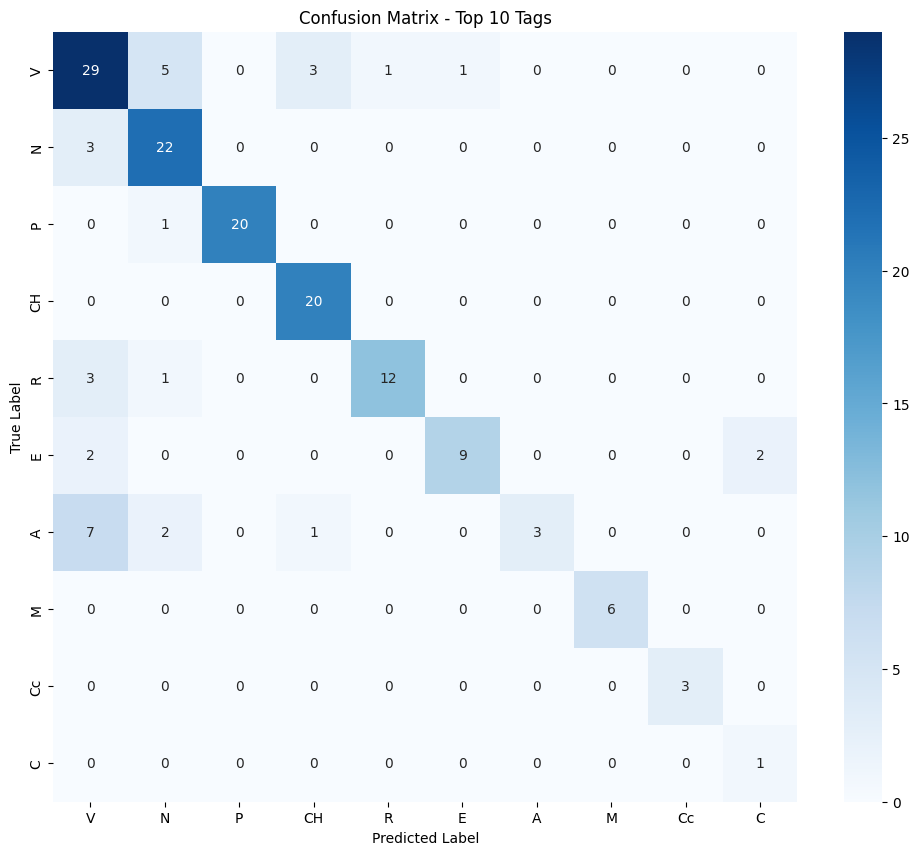


=== Method Comparison ===
       Method  Accuracy     Features
Original MEMM  0.810714 589 features
      Sklearn  0.790123   Same model
Results saved to 'pos_tagging_results.csv'


In [13]:
# Make predictions
print("Making predictions...")
memm.predict(test_data, cutoff=3)

print("Evaluating with original method...")
results = memm.evaluate(test_data, verbose=False)

print("\n" + "="*50)
print("Evaluating with sklearn...")
sklearn_results = memm.evaluate_with_sklearn(test_data, verbose=True)

comparison_data = {
    'Method': ['Original MEMM', 'Sklearn'],
    'Accuracy': [results[1], sklearn_results['overall_accuracy']],
    'Features': [f"{feature_factory.getFeaturesVectorLength()} features", "Same model"]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n=== Method Comparison ===")
print(comparison_df.to_string(index=False))

# Save results to CSV
sklearn_results['summary_df'].to_csv('pos_tagging_results.csv', index=False)
print("Results saved to 'pos_tagging_results.csv'")